In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Task 1: Data Preprocessing & Cleaning**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


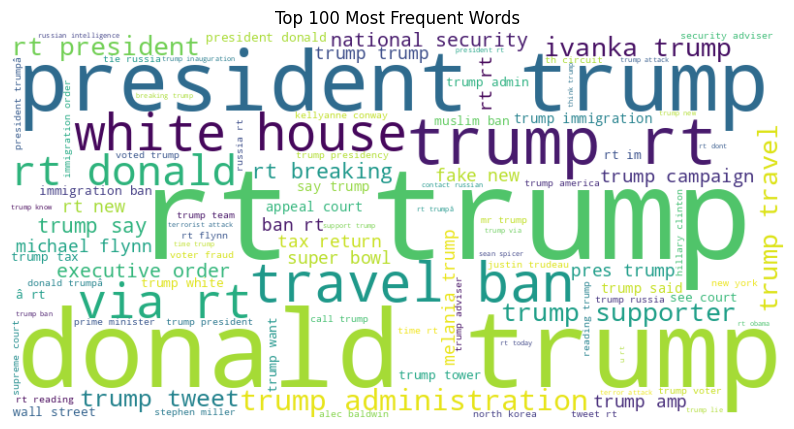

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI&ML/trum_tweet_sentiment_analysis.csv", encoding="ISO-8859-1")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove stopwords and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Visualize with word cloud
all_words = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

**Task 2: Tokenization & Padding**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 1. Verify your DataFrame has 'text' and 'sentiment' columns
print("Columns in DataFrame:", data.columns)  # Debug step

# 2. Split data (adjust column names if needed)
X_train, X_test, y_train, y_test = train_test_split(
    data['text'],           # Features (text data)
    data['Sentiment'],      # Labels (sentiment)
    test_size=0.2,
    random_state=42
)

# 3. Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Only on training data

# 4. Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 5. Padding (95th percentile)
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# 6. Encode labels (if they're strings like 'positive'/'negative')
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Shapes - X_train_pad:", X_train_pad.shape, "y_train_encoded:", y_train_encoded.shape)

Columns in DataFrame: Index(['text', 'Sentiment', 'cleaned_text'], dtype='object')
Shapes - X_train_pad: (1480098, 28) y_train_encoded: (1480098,)


**Task 3: Model Building**

**Simple RNN Model**

In [ ]:
# Import libraries for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

# Set model parameters
vocab_size = min(10000, len(tokenizer.word_index) + 1)  # Limit vocabulary size to 10,000
embedding_dim = 128
rnn_units = 64

# 1. Build Simple RNN Model
print("Building Simple RNN model...")
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(units=rnn_units),
    Dense(1, activation='sigmoid')  # Binary classification
])

rnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(rnn_model.summary())

Building Simple RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


**LSTM Model**

In [ ]:
# 2. Build LSTM Model
print("\nBuilding LSTM model...")
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(units=rnn_units),
    Dense(1, activation='sigmoid')  # Binary classification
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(lstm_model.summary())


Building LSTM model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


**Task 4: Training & Evaluation**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train RNN model
rnn_history = rnn_model.fit(
    X_train_pad, y_train_encoded,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test_encoded),
    callbacks=[early_stop, checkpoint]
)

# Train LSTM model
lstm_history = lstm_model.fit(
    X_train_pad, y_train_encoded,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test_encoded),
    callbacks=[early_stop]
)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Evaluate RNN
print("RNN Model Evaluation:")
evaluate_model(rnn_model, X_test_pad, y_test_encoded)

# Evaluate LSTM
print("\nLSTM Model Evaluation:")
evaluate_model(lstm_model, X_test_pad, y_test_encoded)

Epoch 1/10
23125/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9024 - loss: 0.2391

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 584s 25ms/step - accuracy: 0.9024 - loss: 0.2391 - val_accuracy: 0.9489 - val_loss: 0.1483
Epoch 2/10
23125/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9553 - loss: 0.1301

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 571s 25ms/step - accuracy: 0.9553 - loss: 0.1301 - val_accuracy: 0.9542 - val_loss: 0.1362
Epoch 3/10
23126/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9596 - loss: 0.1189

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 568s 25ms/step - accuracy: 0.9596 - loss: 0.1189 - val_accuracy: 0.9550 - val_loss: 0.1315
Epoch 4/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 616s 24ms/step - accuracy: 0.9614 - loss: 0.1146 - val_accuracy: 0.9543 - val_loss: 0.1345
Epoch 5/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 624s 24ms/step - accuracy: 0.9610 - loss: 0.1157 - val_accuracy: 0.9524 - val_loss: 0.1468
Epoch 6/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 621s 24ms/step - accuracy: 0.9595 - loss: 0.1198 - val_accuracy: 0.9504 - val_loss: 0.1429
Epoch 1/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 1173s 51ms/step - accuracy: 0.9886 - loss: 0.0335 - val_accuracy: 0.9710 - val_loss: 0.0975
Epoch 2/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 1215s 50ms/step - accuracy: 0.9905 - loss: 0.0279 - val_accuracy: 0.9709 - val_loss: 0.1010
Epoch 3/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 1212s 50ms/step - accuracy: 0.9917 - loss: 0.0243 - val_accuracy: 0.9707 - val_loss: 0.1079
Epoch 4/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 1163s 50ms/step - a

**Task 5: Visualization**

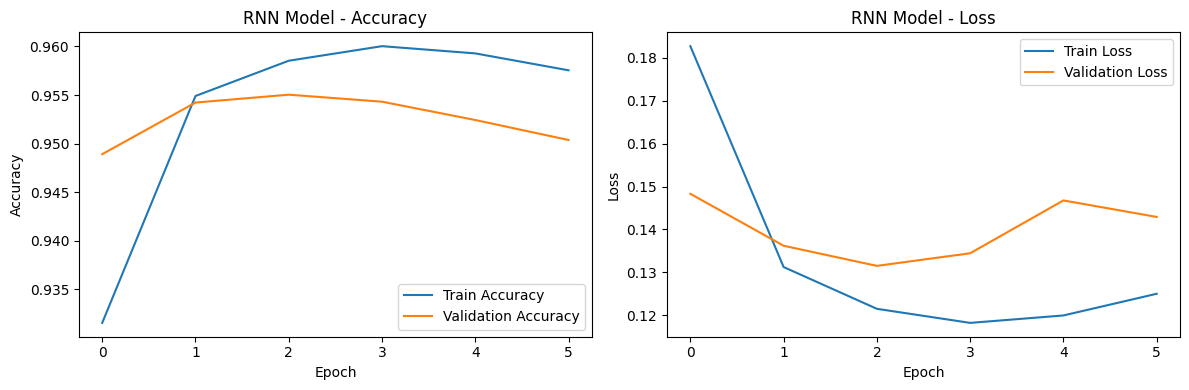

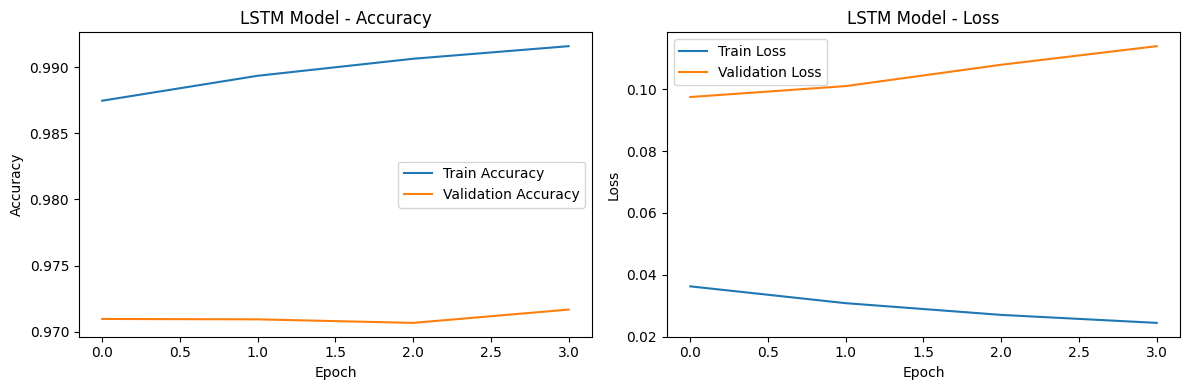

In [28]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot RNN training history
plot_history(rnn_history, 'RNN Model')

# Plot LSTM training history
plot_history(lstm_history, 'LSTM Model')

**Task 6: (Optional) GUI for Real-Time Prediction**

In [1]:
import tkinter as tk
from tkinter import messagebox
from tensorflow.keras.models import load_model

# Load the best model
model = load_model('best_model.h5')

def predict_sentiment(text):
    # Preprocess
    text = preprocess_text(text)
    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    # Predict
    pred = model.predict(padded)[0][0]
    sentiment = 'Positive' if pred > 0.5 else 'Negative'
    confidence = pred if pred > 0.5 else 1 - pred
    return f"{sentiment} (Confidence: {confidence:.2f})"

def on_predict():
    user_input = entry.get()
    if not user_input.strip():
        messagebox.showwarning("Input Error", "Please enter a tweet!")
        return

    result = predict_sentiment(user_input)
    result_label.config(text=f"Predicted Sentiment: {result}")

# Create GUI
root = tk.Tk()
root.title("Twitter Sentiment Analysis")
root.geometry("500x300")

tk.Label(root, text="Enter a tweet:", font=("Arial", 12)).pack(pady=10)
entry = tk.Entry(root, width=50, font=("Arial", 10))
entry.pack(pady=5)

predict_btn = tk.Button(root, text="Predict Sentiment", command=on_predict, font=("Arial", 10))
predict_btn.pack(pady=10)

result_label = tk.Label(root, text="", font=("Arial", 12), fg="blue")
result_label.pack(pady=10)

root.mainloop()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)